# Actividad 5: Programación guiada de uso y fine tuning de arquitecturas robustas para el desarrollo de modelos personalizados

## Mario Hernández

### Implementación de sistema RAG para documentación histórica y cultural de Ipiales

Fuente: https://sired.udenar.edu.co/1401/1/91164.pdf

In [1]:
# Instalo las librerías principales para RAG
!pip install -q langchain
!pip install -q langchain-community
!pip install -q google-generativeai
!pip install -q PyPDF2
!pip install -q sentence-transformers
!pip install langchain-google-genai
!pip install google-genai
!pip install pypdf
!pip install faiss-cpu

# Instalo librerías adicionales para evaluación
!pip install rank_bm25
!pip install datasets
!pip install pandas
!pip install scikit-learn
!pip install nltk
!pip install rouge-score
!pip install bert-score
!pip install athina-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.4/303.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=745cb5c7d8b96be89649f2c8780ef73097e1e36019d8447765bee7765da35a8b
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.5 MB/s eta 0:00:00


In [2]:
import os
from google.colab import userdata

# Configuro mi API key de Google
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [3]:
# Importo librerías para carga de documentos
from langchain.document_loaders import PyPDFLoader
from langchain_community.document_loaders import PyPDFLoader as CommunityPyPDFLoader

# Importo librerías para división de texto
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter

# Importo librerías para embeddings
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain_community.embeddings import SentenceTransformerEmbeddings as CommunitySentenceTransformerEmbeddings

# Importo librerías para bases de datos vectoriales
from langchain.vectorstores import FAISS
from langchain_community.vectorstores import FAISS as CommunityFAISS

# Importo LLM y cadenas
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains import RetrievalQA

# Importo librerías para recuperadores híbridos
from langchain.retrievers import BM25Retriever, EnsembleRetriever

# Importo librerías para prompts y pipelines
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

# Importo librerías para evaluación y métricas
import pandas as pd
from datasets import Dataset
import json
import time
from athina_client.datasets import Dataset
from athina_client.keys import AthinaApiKey
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset as HFDataset
from athina_client.datasets import Dataset

In [6]:
# CARGA Y PROCESAMIENTO DE DOCUMENTOS

# Función para corregir codificación mal interpretada
def fix_encoding(text):
    try:
        return text.encode('latin1').decode('utf-8')
    except:
        return text

# Cargo mi documento
loader = PyPDFLoader("/content/ipiales.pdf")
documents = loader.load()

# Corrijo la codificación de cada página
for doc in documents:
    doc.page_content = fix_encoding(doc.page_content)

print(f"Documento cargado: {len(documents)} páginas")

# Divido el texto en chunks manejables
text_splitter = CharacterTextSplitter(
    chunk_size=1000,   # Tamaño de cada fragmento
    chunk_overlap=200  # Superposición entre fragmentos
)
docs = text_splitter.split_documents(documents)
print(f"Texto dividido en {len(docs)} fragmentos")

Documento cargado: 83 páginas
Texto dividido en 83 fragmentos


In [7]:
# CREACIÓN DE BASE DE DATOS VECTORIAL

# Creo la función de embeddings multilingüe
embedding_function = SentenceTransformerEmbeddings(
    model_name="distiluse-base-multilingual-cased-v1"
)

# Creo la base de datos vectorial FAISS
db = FAISS.from_documents(docs, embedding_function)

# Guardo la base de datos para uso posterior
db.save_local("vector_db_ipi")

<ipython-input-7-a3a5ee407a93>:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = SentenceTransformerEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [ ]:
# CONFIGURACIÓN DE RECUPERADORES

# Creo el recuperador semántico (FAISS)
semantic_retriever = db.as_retriever(search_kwargs={"k": 8})

# Creo el recuperador por palabras clave (BM25)
keyword_retriever = BM25Retriever.from_documents(docs)
keyword_retriever.k = 3

# Creo el recuperador híbrido (ensemble)
ensemble_retriever = EnsembleRetriever(
    retrievers=[semantic_retriever, keyword_retriever],
    weights=[0.5, 0.5]  # Peso igual para ambos métodos
)

In [ ]:
# CONFIGURACIÓN DEL MODELO LLM

# Configuro mi modelo Gemini
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite-001",
    temperature=0.3,        # Controlo la creatividad
    max_output_tokens=1024  # Controlo la longitud de respuesta
)

In [ ]:
# CREACIÓN DEL PIPELINE RAG

# Defino mi template de prompt
template = """
Eres un asistente útil que responde preguntas basándose en el siguiente contexto.
Si no encuentras la respuesta en el contexto, simplemente di que no lo sabes.

Contexto: {context}

Pregunta: {input}

Respuesta:
"""

# Creo el prompt template
prompt = ChatPromptTemplate.from_template(template)

# Creo mi pipeline RAG completo
rag_chain = (
    {"context": ensemble_retriever, "input": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# También creo una cadena simple para comparación
simple_qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=semantic_retriever,
    chain_type="stuff"
)

In [ ]:
# PRUEBAS DEL SISTEMA

# Defino mis preguntas de prueba
test_questions = [
    "¿Quién fue el Pepe?",
    "¿Cómo se llamaba el teatro donde se representaban obras teatrales?",
    "¿Cuál era una aparición común cerca de los riachuelos y qué otras historias había?",
    "¿Qué figura histórica ecuatoriana vivió en Ipiales y qué obra escribió allí?",
    "¿Cuál fue el nombre del almacén que se incendió en la Carrera Sexta?",
    "¿Cómo llamaron a Ipiales durante la época de la violencia liberal conservadora?",
    "¿Quién homenajeó a Simón Bolívar vestida de ninfa?",
    "¿Qué costumbre implicaba echar candado a las puertas para dar serenatas?",
    "¿Cuál era la frase popular que circulaba sobre el pan de maíz en Ipiales?",
    "¿Qué importancia tiene el antiguo Hotel Colombia?"
]

# Pruebo cada pregunta
for i, question in enumerate(test_questions, 1):
    print(f"\nPregunta {i}: {question}")

    # Respuesta con RAG
    rag_response = rag_chain.invoke(question)
    print(f"Con RAG: {rag_response}")

    # Respuesta sin RAG (solo LLM)
    llm_only = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite-001", temperature=0)
    no_rag_response = llm_only.invoke(question)
    print(f"Sin RAG: {no_rag_response.content}")
    print("-" * 80)


Pregunta 1: ¿Quién fue el Pepe?
Con RAG: El Pepe era el hombre más feo de Colombia.
Sin RAG: "El Pepe" es un apodo que se utiliza para referirse a **José Mujica**. Fue un político uruguayo que se desempeñó como Presidente de Uruguay desde 2010 hasta 2015.

Es conocido por su estilo de vida humilde, su defensa de los derechos humanos y su postura progresista en temas como la legalización de la marihuana y el matrimonio igualitario. Su popularidad trascendió las fronteras de Uruguay y se convirtió en una figura admirada a nivel internacional.
--------------------------------------------------------------------------------

Pregunta 2: ¿Cómo se llamaba el teatro donde se representaban obras teatrales?
Con RAG: El teatro donde se representaban obras teatrales se llamaba Teatro Bolívar.
Sin RAG: El teatro donde se representaban obras teatrales se llamaba **teatro**.
--------------------------------------------------------------------------------

Pregunta 3: ¿Cuál era una aparición común c

In [ ]:
# Importo las librerías necesarias para la visualización
from IPython.display import Markdown, display

# @title Pregunta prueba al documento
pregunta = "¿Qué papel jugó la emisora Cultural Bolívar en la música local?" # @param {type:"string"}
response = rag_chain.invoke(pregunta )
display(Markdown(response))

A raíz del programa que hacían los sábados en la Cultural Bolívar, nacieron varios tríos, porque fue un semillero de cultura.

In [ ]:
# CREACIÓN DE DATASET PARA EVALUACIÓN

# Creo listas para almacenar resultados
questions = []
rag_responses = []
contexts = []
no_rag_responses = []
respuestas = [
    "El Pepe era un personaje popular conocido por su fealdad; lo llamaban 'el hombre más feo de Colombia'",
    "En el teatro Bolívar se presentaban actos de todo tipo, pero, como en cualquier teatro, ahí también se representaban obras teatrales.",
    "Una aparición común eran los duendes, que se decía aparecía en los riachuelos. También se hablaba de huacas y otras historias de espanto en la tradición oral.",
    "Juan Montalvo vivió en Ipiales y allí escribió 'Los capítulos que se le olvidaron a Cervantes', inspirado en Don Quijote.",
    "El almacén de nombre Saavedra, ubicado en la carrera sexta, fue el que se incendió.",
    "A Ipiales se la conocía como la ‘Plaza Roja del Sur.",
    "Doña Josefina Obando, quien, vestida de ninfa, en una barca, le dio la bienvenida a Simón Bolívar en Ipiales.",
    "El encargado del candado cogía las argollas de las puertas y les echaba candado para que los papás no pudieran salir a ahuyentar a los serenateros.",
    "Ipialeño que se respete come pan de maíz.",
    "En el Hotel Colombia pernoctó Jorge Eliécer Gaitán"
]


# Proceso cada pregunta para el dataset
llm_only = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite-001", temperature=0.1)

for question in test_questions:
    # Obtengo respuesta RAG
    rag_response = rag_chain.invoke(question)

    # Obtengo contexto relevante
    relevant_docs = ensemble_retriever.get_relevant_documents(question)
    context = [doc.page_content for doc in relevant_docs]

    # Obtengo respuesta sin RAG
    no_rag_response = llm_only.invoke(question)
    time.sleep(1)

    # Almaceno resultados
    questions.append(question)
    rag_responses.append(rag_response)
    contexts.append(context)
    no_rag_responses.append(no_rag_response.content)

# Creo el diccionario de datos
evaluation_data = {
    "query": questions,
    "rag_response": rag_responses,
    "no_rag_response": no_rag_responses,
    "context": contexts,
    "respuesta_correcta": respuestas

}

# Creo el dataset
dataset = HFDataset.from_dict(evaluation_data)
df_evaluation = pd.DataFrame(dataset)

print(f"Dataset creado con {len(df_evaluation)} registros")


Dataset creado con 10 registros


In [ ]:
df_evaluation

,query,rag_response,no_rag_response,context,respuesta_correcta
0,¿Quién fue el Pepe?,El Pepe fue el hombre más feo de Colombia.,"""El Pepe"" es un apodo que se le da a **José Mu...",[41 \n \n \n \nFigura 8. El Pepe. Fotografía d...,El Pepe era un personaje popular conocido por ...
1,¿Cómo se llamaba el teatro donde se representa...,El teatro donde se representaban obras teatral...,El teatro donde se representaban obras teatral...,[47 \n \n \nEn esta anécdota se refiere hasta ...,En el teatro Bolívar se presentaban actos de t...
2,¿Cuál era una aparición común cerca de los ria...,"Los duendes eran una aparición común, sobre to...",La aparición común cerca de los riachuelos es ...,"[45 \n \nJulio, donde dicen que, por lo genera...","Una aparición común eran los duendes, que se d..."
3,¿Qué figura histórica ecuatoriana vivió en Ipi...,"Juan Montalvo, el escritor ecuatoriano, vivió ...",La figura histórica ecuatoriana que vivió en I...,[17 \n \nalgunas casas que han sobrevivido a e...,Juan Montalvo vivió en Ipiales y allí escribió...
4,¿Cuál fue el nombre del almacén que se incendi...,El almacén que se incendió en la Carrera Sexta...,El almacén que se incendió en la Carrera Sexta...,[63 \n \nOcurrió el incendio en la Carrera Sex...,"El almacén de nombre Saavedra, ubicado en la c..."
5,¿Cómo llamaron a Ipiales durante la época de l...,"""La Plaza Roja del Sur""",Durante la época de la Violencia Liberal-Conse...,[61 \n \nUn acontecimiento de importancia a ni...,A Ipiales se la conocía como la ‘Plaza Roja de...
6,¿Quién homenajeó a Simón Bolívar vestida de ni...,"Doña Josefina Obando, vestida de ninfa, homena...",La persona que homenajeó a Simón Bolívar vesti...,[49 \n \nEn el Teatro Bolívar y el Teatro Vela...,"Doña Josefina Obando, quien, vestida de ninfa,..."
7,¿Qué costumbre implicaba echar candado a las p...,La costumbre de echar candado a las puertas er...,La costumbre que implicaba echar candado a las...,[70 \n \n \n \nFigura 17. Escuela de música pa...,El encargado del candado cogía las argollas de...
8,¿Cuál era la frase popular que circulaba sobre...,“Ipialeño que se respete come pan de maíz”.,La frase popular que circulaba sobre el pan de...,[14 \n \nOtro aspecto que se trata en un breve...,Ipialeño que se respete come pan de maíz.
9,¿Qué importancia tiene el antiguo Hotel Colombia?,Se sabe que el antiguo Hotel Colombia fue un l...,El antiguo Hotel Colombia tiene una importanci...,"[40 \n \nEs posible que, para los ipialeños de...",En el Hotel Colombia pernoctó Jorge Eliécer Ga...


In [ ]:
# GUARDADO DE RESULTADOS

# Guardo los resultados en CSV
df_evaluation.to_csv("rag_evaluation_results.csv", index=False)

# Guardo también en JSON para mayor flexibilidad
evaluation_dict = df_evaluation.to_dict(orient='records')
with open("rag_evaluation_results.json", "w", encoding="utf-8") as f:
    json.dump(evaluation_dict, f, ensure_ascii=False, indent=2)

print("Resultados guardados en CSV y JSON")

Resultados guardados en CSV y JSON


In [ ]:
# FUNCIONES DE EVALUACIÓN MANUAL

def compare_responses_manually():
    """Función para comparar respuestas manualmente"""
    print("\n" + "="*60)
    print("COMPARACIÓN MANUAL DE RESPUESTAS")
    print("="*60)

    for i, (question, rag_resp, no_rag_resp) in enumerate(
        zip(questions, rag_responses, no_rag_responses), 1
    ):
        print(f"\n PREGUNTA {i}:")
        print(f"   {question}")
        print(f"\n RESPUESTA CON RAG:")
        print(f"   {rag_resp}")
        print(f"\n RESPUESTA SIN RAG:")
        print(f"   {no_rag_resp}")
        print(f"\n{'='*60}")

def show_context_for_question(question_index):
    """Muestra el contexto recuperado para una pregunta específica"""
    if 0 <= question_index < len(questions):
        print(f"\n CONTEXTO PARA: {questions[question_index]}")
        print("-" * 50)
        for i, ctx in enumerate(contexts[question_index], 1):
            print(f"\nFragmento {i}:")
            print(f"{ctx[:200]}..." if len(ctx) > 200 else ctx)
    else:
        print(" Índice de pregunta inválido")

# Ejecuto la comparación manual
compare_responses_manually()


COMPARACIÓN MANUAL DE RESPUESTAS

 PREGUNTA 1:
   ¿Quién fue el Pepe?

 RESPUESTA CON RAG:
   El Pepe fue el hombre más feo de Colombia.

 RESPUESTA SIN RAG:
   "El Pepe" es un apodo que se le da a **José Mujica**, un político uruguayo que fue Presidente de Uruguay entre 2010 y 2015.

Es conocido por:

*   **Su humildad y estilo de vida sencillo:** Vivía en una modesta granja y donaba gran parte de su salario a organizaciones benéficas.
*   **Su activismo político:** Fue guerrillero del Movimiento de Liberación Nacional-Tupamaros en su juventud y pasó varios años en prisión.
*   **Sus discursos y filosofía de vida:** Es famoso por sus discursos sobre la felicidad, el consumismo y la importancia de la solidaridad.
*   **Su popularidad internacional:** Es una figura muy respetada y admirada en todo el mundo.

En resumen, "El Pepe" se refiere a José Mujica, un expresidente uruguayo conocido por su humildad, activismo y filosofía de vida.


 PREGUNTA 2:
   ¿Cómo se llamaba el teatro donde

In [ ]:
# Inicializo tu Athina API Key
AthinaApiKey.set_key('toI97AgAWbb9c2qTI2AkwFI6pwVKt7Kt')

# Cargo los resultados del CSV
try:
    df_evaluation = pd.read_csv("rag_evaluation_results.csv")
except FileNotFoundError:
    print("Error: El archivo rag_evaluation_results.csv no fue encontrado.")
    exit()


# Preparo los datos (en formato diccionario) para enviar a Athina
# Mapeamos las columnas de nuestro DataFrame a las esperadas por Athina
rows_to_add = []
for index, row in df_evaluation.iterrows():

    context_list = row['context']
    if isinstance(context_list, str):
        try:
            import ast
            context_list = ast.literal_eval(context_list)
        except (ValueError, SyntaxError):
            print(f"Advertencia: No se pudo parsear el contexto para la fila {index}. Se enviará como una lista con un solo elemento.")
            context_list = [str(context_list)]


    rows_to_add.append({
        'query': row['query'],
        'context': context_list,
        'RAG_response': row['rag_response'],
        'Sin_RAG_response': row['no_rag_response'],
        'respuesta_correcta' : row['respuesta_correcta']
    })

# Verifica si hay datos para enviar
if not rows_to_add:
    print("No hay datos válidos para enviar a Athina.")
else:
    # ID del dataset de Athina donde quieres enviar los datos
    dataset_id_to_send = '8ce25ea1-9bf4-4129-a64e-16636e16dd2c'

    # Envía los datos al dataset de Athina
    try:
        print(f"Enviando {len(rows_to_add)} filas al dataset de Athina {dataset_id_to_send}...")
        Dataset.add_rows(
            dataset_id=dataset_id_to_send,
            rows=rows_to_add
        )
        print("Datos enviados exitosamente a Athina.")
    except Exception as e:
        print(f"Error al enviar datos a Athina: {e}")

Enviando 10 filas al dataset de Athina 8ce25ea1-9bf4-4129-a64e-16636e16dd2c...
Datos enviados exitosamente a Athina.


In [ ]:
# Aseguro que las listas de respuestas y referencias estén disponibles
if 'df_evaluation' not in locals():
    print("DataFrame de evaluación no encontrado. Ejecuta las celdas anteriores.")
else:
    # Preparo listas de respuestas y referencias
    rag_responses = df_evaluation['rag_response'].tolist()
    no_rag_responses = df_evaluation['no_rag_response'].tolist()
    # Uso la respuesta correcta como referencia (lista de listas para BLEU)
    references = [[resp] for resp in df_evaluation['respuesta_correcta'].tolist()]
    questions = df_evaluation['query'].tolist()

    # Inicializo el scorer de ROUGE
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    print("\n Calculando métricas automáticas (BLEU y ROUGE)...")

    bleu_scores_rag = []
    rouge1_f_scores_rag = []
    rougeL_f_scores_rag = []

    bleu_scores_no_rag = []
    rouge1_f_scores_no_rag = []
    rougeL_f_scores_no_rag = []

    for i, (q, rag_resp, no_rag_resp, ref) in enumerate(zip(questions, rag_responses, no_rag_responses, references)):
        print(f"\n--- Pregunta {i+1}: {q} ---")

        # Calculo BLEU para RAG vs Referencia
        try:
             bleu_rag = sentence_bleu(ref, rag_resp)
             bleu_scores_rag.append(bleu_rag)
             print(f"  BLEU Score (RAG vs Referencia): {bleu_rag:.4f}")
        except ZeroDivisionError:
             print("  BLEU Score (RAG vs Referencia): N/A (división por cero)")
             bleu_scores_rag.append(0)


        # Calculo ROUGE para RAG vs Referencia
        scores_rag = scorer.score(ref[0], rag_resp) # rouge_scorer espera string de referencia
        rouge1_f_scores_rag.append(scores_rag['rouge1'].fmeasure)
        rougeL_f_scores_rag.append(scores_rag['rougeL'].fmeasure)
        print(f"  ROUGE-1 F1 (RAG vs Referencia): {scores_rag['rouge1'].fmeasure:.4f}")
        print(f"  ROUGE-L F1 (RAG vs Referencia): {scores_rag['rougeL'].fmeasure:.4f}")

        # Métricas para No-RAG vs Referencia para comparación
        try:
            bleu_no_rag = sentence_bleu(ref, no_rag_resp)
            bleu_scores_no_rag.append(bleu_no_rag)
            print(f"  BLEU Score (No-RAG vs Referencia): {bleu_no_rag:.4f}")
        except ZeroDivisionError:
             print("  BLEU Score (No-RAG vs Referencia): N/A (división por cero)")
             bleu_scores_no_rag.append(0)

        scores_no_rag = scorer.score(ref[0], no_rag_resp)
        rouge1_f_scores_no_rag.append(scores_no_rag['rouge1'].fmeasure)
        rougeL_f_scores_no_rag.append(scores_no_rag['rougeL'].fmeasure)
        print(f"  ROUGE-1 F1 (No-RAG vs Referencia): {scores_no_rag['rouge1'].fmeasure:.4f}")
        print(f"  ROUGE-L F1 (No-RAG vs Referencia): {scores_no_rag['rougeL'].fmeasure:.4f}")


    # Calculo promedios
    avg_bleu_rag = sum(bleu_scores_rag) / len(bleu_scores_rag) if bleu_scores_rag else 0
    avg_rouge1_f_rag = sum(rouge1_f_scores_rag) / len(rouge1_f_scores_rag) if rouge1_f_scores_rag else 0
    avg_rougeL_f_rag = sum(rougeL_f_scores_rag) / len(rougeL_f_scores_rag) if rougeL_f_scores_rag else 0

    avg_bleu_no_rag = sum(bleu_scores_no_rag) / len(bleu_scores_no_rag) if bleu_scores_no_rag else 0
    avg_rouge1_f_no_rag = sum(rouge1_f_scores_no_rag) / len(rouge1_f_scores_no_rag) if rouge1_f_scores_no_rag else 0
    avg_rougeL_f_no_rag = sum(rougeL_f_scores_no_rag) / len(rougeL_f_scores_no_rag) if rougeL_f_scores_no_rag else 0


    print("\n--- Resumen de Métricas Promedio ---")
    print(f"  BLEU Promedio (RAG vs Referencia):     {avg_bleu_rag:.4f}")
    print(f"  ROUGE-1 F1 Promedio (RAG vs Referencia): {avg_rouge1_f_rag:.4f}")
    print(f"  ROUGE-L F1 Promedio (RAG vs Referencia): {avg_rougeL_f_rag:.4f}")
    print("-" * 30)
    print(f"  BLEU Promedio (No-RAG vs Referencia):  {avg_bleu_no_rag:.4f}")
    print(f"  ROUGE-1 F1 Promedio (No-RAG vs Referencia): {avg_rouge1_f_no_rag:.4f}")
    print(f"  ROUGE-L F1 Promedio (No-RAG vs Referencia): {avg_rougeL_f_no_rag:.4f}")



 Calculando métricas automáticas (BLEU y ROUGE)...

--- Pregunta 1: ¿Quién fue el Pepe? ---
  BLEU Score (RAG vs Referencia): 0.2170
  ROUGE-1 F1 (RAG vs Referencia): 0.6207
  ROUGE-L F1 (RAG vs Referencia): 0.6207
  BLEU Score (No-RAG vs Referencia): 0.0724
  ROUGE-1 F1 (No-RAG vs Referencia): 0.1039
  ROUGE-L F1 (No-RAG vs Referencia): 0.1039

--- Pregunta 2: ¿Cómo se llamaba el teatro donde se representaban obras teatrales? ---
  BLEU Score (RAG vs Referencia): 0.3616
  ROUGE-1 F1 (RAG vs Referencia): 0.5714
  ROUGE-L F1 (RAG vs Referencia): 0.3429
  BLEU Score (No-RAG vs Referencia): 0.3080
  ROUGE-1 F1 (No-RAG vs Referencia): 0.4848
  ROUGE-L F1 (No-RAG vs Referencia): 0.3636

--- Pregunta 3: ¿Cuál era una aparición común cerca de los riachuelos y qué otras historias había? ---
  BLEU Score (RAG vs Referencia): 0.4171
  ROUGE-1 F1 (RAG vs Referencia): 0.5435
  ROUGE-L F1 (RAG vs Referencia): 0.3261
  BLEU Score (No-RAG vs Referencia): 0.0737
  ROUGE-1 F1 (No-RAG vs Referencia): 0

Interpretación de los resultados:

* **BLEU:** Mide la precisión de los n-gramas en la respuesta generada en comparación con la referencia. Un valor más alto indica una mayor superposición de palabras y frases, sugiriendo que la respuesta es similar a la referencia. Comparar el BLEU de la respuesta RAG con el de la respuesta sin RAG te mostrará si la respuesta RAG se parece más a la respuesta correcta esperada.

* **ROUGE:** Se centra en el recuerdo (recall) y la precisión de la superposición de unidades lingüísticas (unigramas, bigramas, secuencias más largas) entre la respuesta generada y la referencia. ROUGE-1 mide la superposición de unigramas, ROUGE-2 de bigramas y ROUGE-L de la secuencia común más larga. Un valor más alto en ROUGE sugiere que la respuesta generada captura información relevante de la referencia. Comparar las puntuaciones ROUGE te ayudará a ver si el RAG está extrayendo y utilizando la información correcta del contexto.

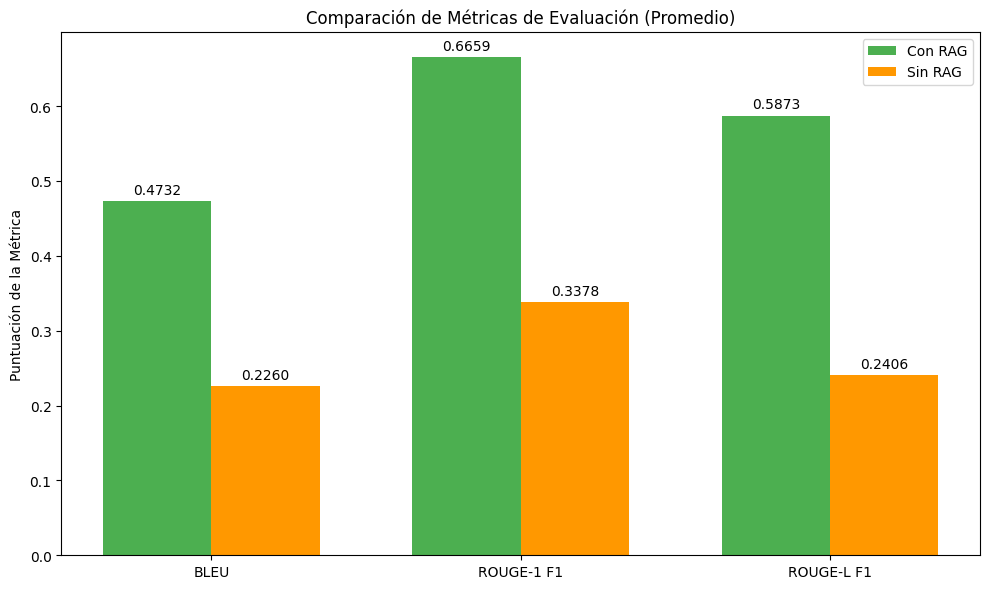

In [ ]:
# Datos para graficar
labels = ['BLEU', 'ROUGE-1 F1', 'ROUGE-L F1']
rag_scores = [avg_bleu_rag, avg_rouge1_f_rag, avg_rougeL_f_rag]
no_rag_scores = [avg_bleu_no_rag, avg_rouge1_f_no_rag, avg_rougeL_f_no_rag]

x = np.arange(len(labels))  # Posiciones de las etiquetas en el eje X
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, rag_scores, width, label='Con RAG', color='#4CAF50')
rects2 = ax.bar(x + width/2, no_rag_scores, width, label='Sin RAG', color='#FF9800')

ax.set_ylabel('Puntuación de la Métrica')
ax.set_title('Comparación de Métricas de Evaluación (Promedio)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Función para añadir etiquetas en las barras
def autolabel(rects):
  for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height:.4f}',
    xy=(rect.get_x() + rect.get_width() / 2, height),
    xytext=(0, 3),
    textcoords="offset points",
    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()